In [1]:
import sys
from watermarkJPEG import *
from JPEG_layer import * # some utils.

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# you may need to modify this according to your environemnt and tf version.

In [3]:
print('TensorFlow version: ',tf.__version__)
print('Python version:', sys.version)

TensorFlow version:  2.1.0
Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]


In [4]:
np.random.seed(7)
wm_secret_key = np.random.randint(10000, size=50000)
#wm_secret_key = np.load('watermark_secret_key.npy')
assert wm_secret_key[0] == 9412
# each image are assigned an secret key; and its corresponding secret information are binary sequence generated based these keys.

In [5]:
labels = np.load('first_20_labels.npy')
# I downloaded ImageNet dataset in my local computer. 
# I have included first 20 images and their labels in this respository for testing.
print(labels)

[ 65 970 230 809 516  57 334 415 674 332 109 286 370 757 595 147 108  23
 478 517]


In [6]:
nb_images = 20
pixel_shape = 224
clip_min = -1

# pgd_thresh = 0.3
# pgd_step = 0.007843
# pgd_nb_step = 16
# fgm_step = 0.125
full_dataset_loc = 'dataset/'

# Watermarking algorithm

In [7]:
def find_zigzag(a):
    assert a>=0 and a<=64
    zigzag = np.array((        [[0,   1,   5,  6,   14,  15,  27,  28],
    [2,   4,   7,  13,  16,  26,  29,  42],
    [3,   8,  12,  17,  25,  30,  41,  43],
    [9,   11, 18,  24,  31,  40,  44,  53],
    [10,  19, 23,  32,  39,  45,  52,  54],
    [20,  22, 33,  38,  46,  51,  55,  60],
    [21,  34, 37,  47,  50,  56,  59,  61],
    [35,  36, 48,  49,  57,  58,  62,  63]]))
    
    for i in range(8):
        for j in range(8):
            if zigzag[i][j] == a:
                return i,j
            
# it is not the best practice; you can get the default dqt through computation; but this way is convinient
def get_default_dqt_Y_by_qf(qualityf):# tested
    ori_image = cv2.imread('dataset/ILSVRC2012_val_00000001.JPEG')
    cv2.imwrite('dataset/temp_delete_me.jpeg',ori_image,[int(cv2.IMWRITE_JPEG_QUALITY), qualityf])
    return get_quantization_table('dataset/temp_delete_me.jpeg')[0]

The watermarking was only conducted on Y (luminance) channel. because it means the most for vision. This watermarking method is the one described in the watermarking paper, which involves a reference switch bit for each block.

In [8]:
def watermark_embedding_type_4(fn_image, rand_seed, custimize_dqt = False, wm_qf = 50):
    # if custimize_dqt == False, use original image's dqt
    #return the watermarked image in YUV, but not quantized.
    ref_bits_all = []
    
    rand_index = 0
    np.random.seed(rand_seed)
    img = cv2.imread(fn_image).astype('float32') # to read image in a fancier way, please refer to https://github.com/uber-research/jpeg2dct
    
    key_size = img.shape[-2]*img.shape[-3]/64 * (5*10)
    key_size = max(key_size, 500000)
    wm_secret_key = np.random.randint(2, size=int(key_size))
    #img_height = img.shape[0]
    #img_width = img.shape[0]
    img_YUV = cv2.cvtColor(img/255, cv2.COLOR_BGR2YUV)*255
    img_Y = img_YUV[:,:,0].copy()
    wm_image_YUV = img_YUV.copy()
    
    dqt_y, dqt_c = get_quantization_table(fn_image)
    if custimize_dqt == True:
        dqt_y = get_default_dqt_Y_by_qf(wm_qf)
        
    block_index = -1
    for i in range(0,int(np.floor(img_YUV.shape[0]/8)*8),8):
        for j in range(0,int(np.floor(img_YUV.shape[1]/8)*8),8):
            block_index += 1
            current_block = img_Y[i:i+8,j:j+8]
            block_dct = cv2.dct(current_block)

            nb_inserted_coef = 0
            positions = []
            while nb_inserted_coef < 5:
                current_key = wm_secret_key[rand_index*5:rand_index*5+5]
                rand_index += 1
                #print(current_key)
                wm_position = current_key[0]*8 + current_key[1]*4 + current_key[2]*2 + current_key[3]
                wm_value = current_key[4]
                
                if nb_inserted_coef == 0:
                    positions.append(wm_position)
                    nb_inserted_coef += 1
                    temp_i, temp_j = find_zigzag(wm_position)
                    quanted_coef = block_dct[temp_i][temp_j]
                    quanted_coef = np.round(quanted_coef/dqt_y[temp_i][temp_j])
                    #quanted_coef += 1e-4 # avoid some precision loss
                    ref_bit = np.floor(quanted_coef/2**(wm_value + 1))%2
                    assert int(ref_bit) in [0,1]
                    
                    ref_bits_all.append(ref_bit)
                    block_dct[temp_i][temp_j] = quanted_coef*dqt_y[temp_i][temp_j]
                else:
                    wm_value = wm_value^int(ref_bit)
                
                if wm_position not in positions:
                    nb_inserted_coef += 1
                    positions.append(wm_position)
                    temp_i, temp_j = find_zigzag(wm_position)
                    quanted_coef = block_dct[temp_i][temp_j]
                    quanted_coef = quanted_coef/dqt_y[temp_i][temp_j]
                    quanted_coef += 1e-4 # avoid some precision loss
                    if quanted_coef%1 == 0:
                        quanted_coef = np.floor(quanted_coef/2)*2+wm_value
                        assert quanted_coef%2 == wm_value
                    else:
                        if np.ceil(quanted_coef)%2 != wm_value:
                            quanted_coef = np.floor(quanted_coef)
                            assert quanted_coef%2 == wm_value
                        elif np.floor(quanted_coef)%2 != wm_value:
                            quanted_coef = np.ceil(quanted_coef)
                            assert quanted_coef%2 == wm_value
                        else:
                            print('Error: some case not considered')
                    block_dct[temp_i][temp_j] = quanted_coef*dqt_y[temp_i][temp_j]
                    if quanted_coef%2 != wm_value:
                        print('bad bit')

            new_block = cv2.idct(block_dct)
            wm_image_YUV[i:i+8,j:j+8,0] = new_block
    
    
    
    return wm_image_YUV, ref_bits_all # You don't need to handle ref_bits_all. I added this output for validating my result only.

def watermark_validation_type_4(image, fn_image, rand_seed, custimize_dqt = False, wm_qf = 50, YUV = True):
    ref_bits_all = []
    
    good_bit = 0
    bad_bit = 0
    
    rand_index = 0
    np.random.seed(rand_seed)
    key_size = image.shape[-2]*image.shape[-3]/64 * (5*10)
    key_size = max(key_size, 500000)
    wm_secret_key = np.random.randint(2, size=int(key_size))
    
    #if YUV == True:
    img_YUV = image
    img_Y = img_YUV[:,:,0].copy()
    dqt_y, dqt_c = get_quantization_table(fn_image)
    if custimize_dqt == True:
        dqt_y = get_default_dqt_Y_by_qf(wm_qf)
        
    block_index = -1
    for i in range(0,int(np.floor(img_YUV.shape[0]/8)*8),8):
        for j in range(0,int(np.floor(img_YUV.shape[1]/8)*8),8):
            block_index += 1
            current_block = img_Y[i:i+8,j:j+8]
            block_dct = cv2.dct(current_block)

            nb_inserted_coef = 0
            positions = []
            while nb_inserted_coef < 5:
                current_key = wm_secret_key[rand_index*5:rand_index*5+5]
                rand_index += 1
                #print(current_key)
                wm_position = current_key[0]*8 + current_key[1]*4 + current_key[2]*2 + current_key[3]
                wm_value = current_key[4]
                if nb_inserted_coef == 0:
                    positions.append(wm_position)
                    nb_inserted_coef += 1
                    temp_i, temp_j = find_zigzag(wm_position)
                    quanted_coef = block_dct[temp_i][temp_j]
                    quanted_coef = np.round(quanted_coef/dqt_y[temp_i][temp_j])
                    #quanted_coef += 1e-4 # avoid some precision loss
                    ref_bit = np.floor(quanted_coef/2**(wm_value + 1))%2
                    assert int(ref_bit) in [0,1]
                    ref_bits_all.append(ref_bit)
                else:
                    wm_value = wm_value^int(ref_bit)
                if wm_position not in positions:
                    nb_inserted_coef += 1
                    positions.append(wm_position)
                    temp_i, temp_j = find_zigzag(wm_position)
                    quanted_coef = block_dct[temp_i][temp_j]
                    #quanted_coef += 1e-4 # avoid some precision loss
                    quanted_coef = np.round(quanted_coef/dqt_y[temp_i][temp_j])
                    if quanted_coef%2 == wm_value:
                        good_bit += 1
                    else:
                        bad_bit += 1
    return bad_bit/(good_bit + bad_bit), ref_bits_all

## test watermarking

In [9]:
get_default_dqt_Y_by_qf(50)# default dqt for QF = 50 in Y channel

array([[ 16.,  11.,  10.,  16.,  24.,  40.,  51.,  61.],
       [ 12.,  12.,  14.,  19.,  26.,  58.,  60.,  55.],
       [ 14.,  13.,  16.,  24.,  40.,  57.,  69.,  56.],
       [ 14.,  17.,  22.,  29.,  51.,  87.,  80.,  62.],
       [ 18.,  22.,  37.,  56.,  68., 109., 103.,  77.],
       [ 24.,  35.,  55.,  64.,  81., 104., 113.,  92.],
       [ 49.,  64.,  78.,  87., 103., 121., 120., 101.],
       [ 72.,  92.,  95.,  98., 112., 100., 103.,  99.]])

In [10]:
nb_images = 20
custimize_dqt_switch = True
wm_image_set = []
for i in range(nb_images):
    img_index = i
    fn_ori_image = 'ILSVRC2012_val_00'
    for j in range(6-len(str(img_index+1))):
        fn_ori_image += '0'
    fn_ori_image += str(img_index+1) +'.JPEG' 
    
    wm_image, ref_1 = watermark_embedding_type_4(full_dataset_loc+fn_ori_image, wm_secret_key[i],custimize_dqt = custimize_dqt_switch)
    wm_image_RGB = cv2.cvtColor(wm_image/255, cv2.COLOR_YUV2RGB)*255
    wm_image_set.append(wm_image_RGB)
    #np.save(final_wm_image_warehouse+fn_ori_image+'.npy', wm_image_RGB)

    result, ref_2 = watermark_validation_type_4(wm_image, full_dataset_loc+fn_ori_image, wm_secret_key[i],
                                                   custimize_dqt = custimize_dqt_switch)
    print(fn_ori_image, '\nBER:', result,'ref bits consistent:', ref_1 == ref_2)


ILSVRC2012_val_00000001.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000002.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000003.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000004.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000005.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000006.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000007.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000008.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000009.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000010.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000011.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000012.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000013.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000014.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000015.JPEG 
BER: 0.0 ref bits consistent: True
ILSVRC2012_val_00000016.J

All embedded watermark bits can be reconstructed; the yielded BER is always zero, indicating a zero false-positive rate.

In [11]:
#against JPEG re-compression
nb_images = 20
custimize_dqt_switch = True
for i in range(nb_images):
    img_index = i
    fn_ori_image = 'ILSVRC2012_val_00'
    for j in range(6-len(str(img_index+1))):
        fn_ori_image += '0'
    fn_ori_image += str(img_index+1) +'.JPEG' 
    
    wm_image_RGB = wm_image_set[i]
    
    _ = cv2.imread('dataset/ILSVRC2012_val_00000001.JPEG')
    cv2.imwrite('dataset/temp_delete_me.jpeg',_,[int(cv2.IMWRITE_JPEG_QUALITY), 70])
    dqt_y, dqt_c = get_quantization_table('dataset/temp_delete_me.jpeg') # get dqt for qf=70
    
    jpeg_wm_RGB = jpeg_compress_decompress_exact(tf.convert_to_tensor(np.expand_dims(wm_image_RGB,axis=0)), wm_image_RGB.shape[-3], wm_image_RGB.shape[-2], dqt_y, dqt_c)#
    jpeg_wm_RGB = np.array(jpeg_wm_RGB)
    jpeg_wm_RGB = jpeg_wm_RGB.squeeze()
    jpeg_wm_YUV = cv2.cvtColor(jpeg_wm_RGB/255, cv2.COLOR_RGB2YUV)*255

    result, _ = watermark_validation_type_4(jpeg_wm_YUV, full_dataset_loc+fn_ori_image, wm_secret_key[i],
                                                   custimize_dqt = custimize_dqt_switch)
    print(fn_ori_image, '\nBER:', result)

ILSVRC2012_val_00000001.JPEG 
BER: 0.0
ILSVRC2012_val_00000002.JPEG 
BER: 0.0015778401122019635
ILSVRC2012_val_00000003.JPEG 
BER: 0.0
ILSVRC2012_val_00000004.JPEG 
BER: 0.0001753155680224404
ILSVRC2012_val_00000005.JPEG 
BER: 0.0003933910306845004
ILSVRC2012_val_00000006.JPEG 
BER: 0.0003506311360448808
ILSVRC2012_val_00000007.JPEG 
BER: 0.0026553894571203778
ILSVRC2012_val_00000008.JPEG 
BER: 0.0
ILSVRC2012_val_00000009.JPEG 
BER: 0.006924964936886395
ILSVRC2012_val_00000010.JPEG 
BER: 0.0
ILSVRC2012_val_00000011.JPEG 
BER: 0.004516129032258065
ILSVRC2012_val_00000012.JPEG 
BER: 0.004228953579858379
ILSVRC2012_val_00000013.JPEG 
BER: 0.0
ILSVRC2012_val_00000014.JPEG 
BER: 0.02702470830473576
ILSVRC2012_val_00000015.JPEG 
BER: 0.0
ILSVRC2012_val_00000016.JPEG 
BER: 0.003245476003147128
ILSVRC2012_val_00000017.JPEG 
BER: 0.005960729312762973
ILSVRC2012_val_00000018.JPEG 
BER: 0.001040582726326743
ILSVRC2012_val_00000019.JPEG 
BER: 0.002805049088359046
ILSVRC2012_val_00000020.JPEG 
BER:

After one round of JPEG re-compression with QF = 70, the BER is still very small.

# Adversarial attacks

cleverhans is used here.https://github.com/cleverhans-lab/cleverhans/tree/master/cleverhans/tf2
PGD, FGSM and CW-l2 attacks are used here. Please refer to the watermarking paper for the parameters.
At the time of this implementation, CW-l2 attack for tf2 was not available from cleverhans. Instead, I used an alternative implementation. The usage may not be the same as current cleverhans. The results should be similar though.

In [12]:
model = ResNet50V2(weights='imagenet')# this is a keras pre-trained model. input size = (224,224), data range = [-1,1]
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [13]:
# get the classification accuracy on 20 images:
classified_correctly = []
for i in range(20):
    img_index = i
    fn_ori_image = 'ILSVRC2012_val_00'
    for j in range(6-len(str(i+1))):
        fn_ori_image += '0'
    fn_ori_image += str(i+1) +'.JPEG' 
    
    img = image.load_img(full_dataset_loc+fn_ori_image, target_size=(224, 224))
    x = image.img_to_array(img)
    #if is_gray2(x):
     #   print('gay images',i+1)
    x = np.expand_dims(x, axis=0)
    x_prep = preprocess_input(x)
    pred = np.argmax(model.predict(x_prep), axis = 1)
    if pred == labels[i]:
        classified_correctly.append(i)
print('Top-1 accuracy:',len(classified_correctly)/nb_images*100,'%')
print('images classified correctly:', classified_correctly)

Top-1 accuracy: 65.0 %
images classified correctly: [2, 3, 4, 6, 10, 11, 12, 13, 14, 15, 17, 18, 19]


Attack images that are already misclassified is less meaningful. Next, we attack these classified correctly images.

In [14]:
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


In [15]:
result = []
for i in classified_correctly:
    fn_ori_image = 'ILSVRC2012_val_00'
    for j in range(6-len(str(i+1))):
        fn_ori_image += '0'
    fn_ori_image += str(i+1) +'.JPEG'
    
    img_BGR = cv2.imread(full_dataset_loc + fn_ori_image).astype('float32') # to read image in a fancier way, please refer to https://github.com/uber-research/jpeg2dct
    img_RGB = cv2.cvtColor(img_BGR/255, cv2.COLOR_BGR2RGB)*255

    quant_lumin, quant_uv = get_quantization_table(full_dataset_loc + fn_ori_image)

    model_new, logits_new = build_specific_model(img_RGB.shape[-3], img_RGB.shape[-2], model, enable_jpeg = False, quant_lumin = quant_lumin, quant_uv = quant_uv)
    # for type 1 adaptive adversary, just set enable_jpeg = True; all others are the same as adaptive adversary type 1

    attacked_image = fast_gradient_method(logits_new, tf.convert_to_tensor(np.expand_dims(wm_image_set[i], axis=0)), 8, np.inf, clip_min = 0, clip_max = 255)
    attacked_image_YUV = attacked_image.numpy().squeeze()
    attacked_image_YUV = cv2.cvtColor(attacked_image_YUV/255, cv2.COLOR_RGB2YUV)*255
    BER, _ = watermark_validation_type_4(attacked_image_YUV, full_dataset_loc+fn_ori_image, wm_secret_key[i],
                                                   custimize_dqt = custimize_dqt_switch)
    result.append([fn_ori_image, BER])
    
#     print('clean image pred: ', np.argmax(model_new.predict(tf.convert_to_tensor(np.expand_dims(wm_image_set[i], axis=0))), axis = 1))
#     print('attacked image pred: ', np.argmax(model_new.predict(attacked_image), axis = 1))
    
    
for i in range(len(classified_correctly)):
    print(result[i][0], '     BER after FGSM, eps = 8:',result[i][1])

ILSVRC2012_val_00000003.JPEG      BER after FGSM, eps = 8: 0.40848527349228614
ILSVRC2012_val_00000004.JPEG      BER after FGSM, eps = 8: 0.4321528751753156
ILSVRC2012_val_00000005.JPEG      BER after FGSM, eps = 8: 0.41915814319433514
ILSVRC2012_val_00000007.JPEG      BER after FGSM, eps = 8: 0.41247049567269867
ILSVRC2012_val_00000011.JPEG      BER after FGSM, eps = 8: 0.3970161290322581
ILSVRC2012_val_00000012.JPEG      BER after FGSM, eps = 8: 0.4132572777340677
ILSVRC2012_val_00000013.JPEG      BER after FGSM, eps = 8: 0.41876475216365067
ILSVRC2012_val_00000014.JPEG      BER after FGSM, eps = 8: 0.42493136582017843
ILSVRC2012_val_00000015.JPEG      BER after FGSM, eps = 8: 0.3766784063394233
ILSVRC2012_val_00000016.JPEG      BER after FGSM, eps = 8: 0.4137490165224233
ILSVRC2012_val_00000018.JPEG      BER after FGSM, eps = 8: 0.4110952133194589
ILSVRC2012_val_00000019.JPEG      BER after FGSM, eps = 8: 0.4284712482468443
ILSVRC2012_val_00000020.JPEG      BER after FGSM, eps = 8: 

FGSM introduces large amount of perturbation, and the watermarking bits are sevely distorted, yielding a near 0.5 BER, hence can be detected

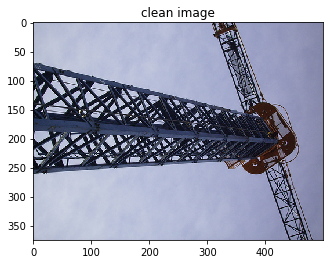

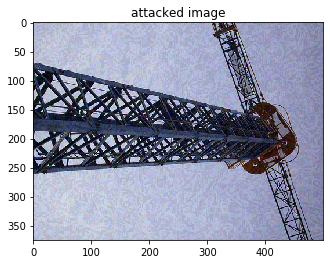

clean image pred:  [517]
attacked image pred:  [540]


In [16]:
plt.imshow(img_RGB/255)
plt.title('clean image')
plt.show()

plt.imshow(attacked_image.numpy().squeeze()/255)
plt.title('attacked image')
plt.show()

print('clean image pred: ', np.argmax(model_new.predict(np.expand_dims(img_RGB, axis=0)), axis = 1))
print('attacked image pred: ', np.argmax(model_new.predict(attacked_image), axis = 1))

In [17]:
result = []
for i in classified_correctly:
    fn_ori_image = 'ILSVRC2012_val_00'
    for j in range(6-len(str(i+1))):
        fn_ori_image += '0'
    fn_ori_image += str(i+1) +'.JPEG'
    
    img_BGR = cv2.imread(full_dataset_loc + fn_ori_image).astype('float32') # to read image in a fancier way, please refer to https://github.com/uber-research/jpeg2dct
    img_RGB = cv2.cvtColor(img_BGR/255, cv2.COLOR_BGR2RGB)*255

    quant_lumin, quant_uv = get_quantization_table(full_dataset_loc + fn_ori_image)

    model_new, logits_new = build_specific_model(img_RGB.shape[-3], img_RGB.shape[-2], model, enable_jpeg = False, quant_lumin = quant_lumin, quant_uv = quant_uv)
    # for type 1 adaptive adversary, just set enable_jpeg = True; all others are the same as adaptive adversary type 1

    attacked_image = fast_gradient_method(logits_new, tf.convert_to_tensor(np.expand_dims(wm_image_set[i], axis=0)), 2, np.inf, clip_min = 0, clip_max = 255)
    attacked_image_YUV = attacked_image.numpy().squeeze()
    attacked_image_YUV = cv2.cvtColor(attacked_image_YUV/255, cv2.COLOR_RGB2YUV)*255
    BER, _ = watermark_validation_type_4(attacked_image_YUV, full_dataset_loc+fn_ori_image, wm_secret_key[i],
                                                   custimize_dqt = custimize_dqt_switch)
    result.append([fn_ori_image, BER])
    
#     print('clean image pred: ', np.argmax(model_new.predict(tf.convert_to_tensor(np.expand_dims(wm_image_set[i], axis=0))), axis = 1))
#     print('attacked image pred: ', np.argmax(model_new.predict(attacked_image), axis = 1))
    
    
for i in range(len(classified_correctly)):
    print(result[i][0], '     BER after FGSM, eps = 2:',result[i][1])

ILSVRC2012_val_00000003.JPEG      BER after FGSM, eps = 2: 0.04014726507713885
ILSVRC2012_val_00000004.JPEG      BER after FGSM, eps = 2: 0.05014025245441795
ILSVRC2012_val_00000005.JPEG      BER after FGSM, eps = 2: 0.04356805664830842
ILSVRC2012_val_00000007.JPEG      BER after FGSM, eps = 2: 0.031372934697088906
ILSVRC2012_val_00000011.JPEG      BER after FGSM, eps = 2: 0.037016129032258066
ILSVRC2012_val_00000012.JPEG      BER after FGSM, eps = 2: 0.03688040912667191
ILSVRC2012_val_00000013.JPEG      BER after FGSM, eps = 2: 0.0470102281667978
ILSVRC2012_val_00000014.JPEG      BER after FGSM, eps = 2: 0.07395332875772134
ILSVRC2012_val_00000015.JPEG      BER after FGSM, eps = 2: 0.02338762931983271
ILSVRC2012_val_00000016.JPEG      BER after FGSM, eps = 2: 0.03412667191188041
ILSVRC2012_val_00000018.JPEG      BER after FGSM, eps = 2: 0.05170395421436004
ILSVRC2012_val_00000019.JPEG      BER after FGSM, eps = 2: 0.06285063113604489
ILSVRC2012_val_00000020.JPEG      BER after FGSM, e

The distortion is much smaller, but the detection rate is still high.

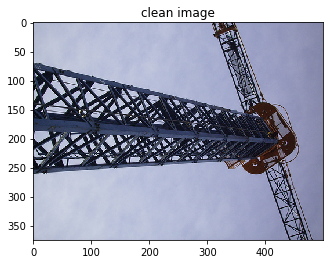

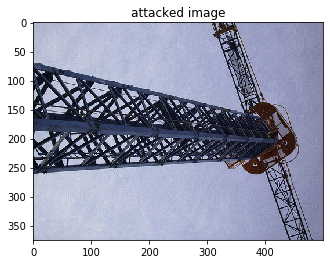

clean image pred:  [517]
attacked image pred:  [540]


In [18]:
plt.imshow(img_RGB/255)
plt.title('clean image')
plt.show()

plt.imshow(attacked_image.numpy().squeeze()/255)
plt.title('attacked image')
plt.show()

print('clean image pred: ', np.argmax(model_new.predict(np.expand_dims(img_RGB, axis=0)), axis = 1))
print('attacked image pred: ', np.argmax(model_new.predict(attacked_image), axis = 1))